## Data transformation and feature engineering

** Basado en el EDA, este notebook se enfoca en la Ingeniería y Preprocesamiento de Datos. La tarea crítica es la Creación de la Variable Objetivo Binaria (Ausentismo_Alto) a partir de Absenteeism time in hours, estableciendo un umbral θ para el Alto Riesgo. Además, transformamos los Códigos ICD-10 (causas médicas) mediante One-Hot Encoding para que el modelo pueda diferenciar el impacto predictivo de cada grupo de enfermedad y motivo logístico. Se realiza la gestión de los valores nulos (6% de ausencias sin razón) y el escalado de variables operacionales (Service time, Distance) para optimizar el rendimiento de los algoritmos de Machine Learning.

In [ ]:
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [ ]:
df = pd.read_csv('../data/raw/work_absenteeism_original.csv')

In [ ]:
## First we will rename all columsn to snake_case for easier handling
column_names = [column for column in df.columns]
print(f"Old column names {column_names}")
print()

def to_snake_case(text):
    text = re.sub(r'(?<!^)(?=[A-Z])', '_', text).lower()
    return text

df.columns = [x.lower() for x in df.columns]
df.columns = df.columns.str.replace("[ ]", "_", regex=True)

column_names = [column for column in df.columns]
print(f"New column names {column_names}")


Old column names ['ID', 'Reason for absence', 'Month of absence', 'Day of the week', 'Seasons', 'Transportation expense', 'Distance from Residence to Work', 'Service time', 'Age', 'Work load Average/day', 'Hit target', 'Disciplinary failure', 'Education', 'Son', 'Social drinker', 'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index', 'Absenteeism time in hours']

New column names ['id', 'reason_for_absence', 'month_of_absence', 'day_of_the_week', 'seasons', 'transportation_expense', 'distance_from_residence_to_work', 'service_time', 'age', 'work_load_average/day', 'hit_target', 'disciplinary_failure', 'education', 'son', 'social_drinker', 'social_smoker', 'pet', 'weight', 'height', 'body_mass_index', 'absenteeism_time_in_hours']


In [ ]:
def plot_numerical_boxplots(df, numerical_columns=None):
    # If numerical_columns is not provided, select all numerical columns
    if numerical_columns is None:
        numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

    # Set up the figure and axes
    n_cols = len(numerical_columns)
    n_rows = (n_cols + 2) // 3  # Adjust rows for a 3-column grid
    fig, axes = plt.subplots(n_rows, min(n_cols, 3), figsize=(15, 5 * n_rows))

    # Flatten axes for easier iteration
    axes = axes.flatten() if n_cols > 1 else [axes]

    # Create a boxplot for each numerical column
    for i, col in enumerate(numerical_columns):
        sns.boxplot(y=df[col], ax=axes[i])
        axes[i].set_title(f'Boxplot of {col}')
        axes[i].set_ylabel(col)

    # Remove empty subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [ ]:
columns_to_drop = ['id', 'body_mass_index']
numerical_columns = ['transportation_expense', 'distance_from_residence_to_work', 'service_time', 'age', 'work_load_average/day', 'hit_target', 'son', 'pet', 'weight', 'height']
categorical_columns = ['reason_for_absence', 'month_of_absence', 'day_of_the_week', 'seasons', 'disciplinary_failure', 'education', 'social_drinker', 'social_smoker']

In [ ]:
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        # Drop only the columns that exist in the DataFrame
        columns_to_drop = [col for col in self.columns_to_drop if col in X.columns]
        if columns_to_drop:
            X = X.drop(columns_to_drop, axis=1)
        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            raise ValueError("input_features must be provided")
        return [col for col in input_features if col not in self.columns_to_drop]


class IQRClippingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lower_bounds_ = {}
        self.upper_bounds_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        for col in X.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            self.lower_bounds_[col] = Q1 - 1.5 * IQR
            self.upper_bounds_[col] = Q3 + 1.5 * IQR
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col in X.columns:
            X[col] = X[col].clip(lower=self.lower_bounds_.get(col),
                                upper=self.upper_bounds_.get(col))
        return X

    def get_feature_names_out(self, input_features=None):
        return input_features if input_features is not None else self.columns_


pipeline = Pipeline([
    ('drop_columns', DropColumnsTransformer(columns_to_drop)),
    ('preprocess', ColumnTransformer(
        transformers=[
            ('numerical', Pipeline([
                ('iqr_clipping', IQRClippingTransformer()),
                ('scaling', StandardScaler())
            ]), numerical_columns)
        ],
        remainder='passthrough'
    ))
])


In [ ]:
transformed_data = pipeline.fit_transform(df[numerical_columns])

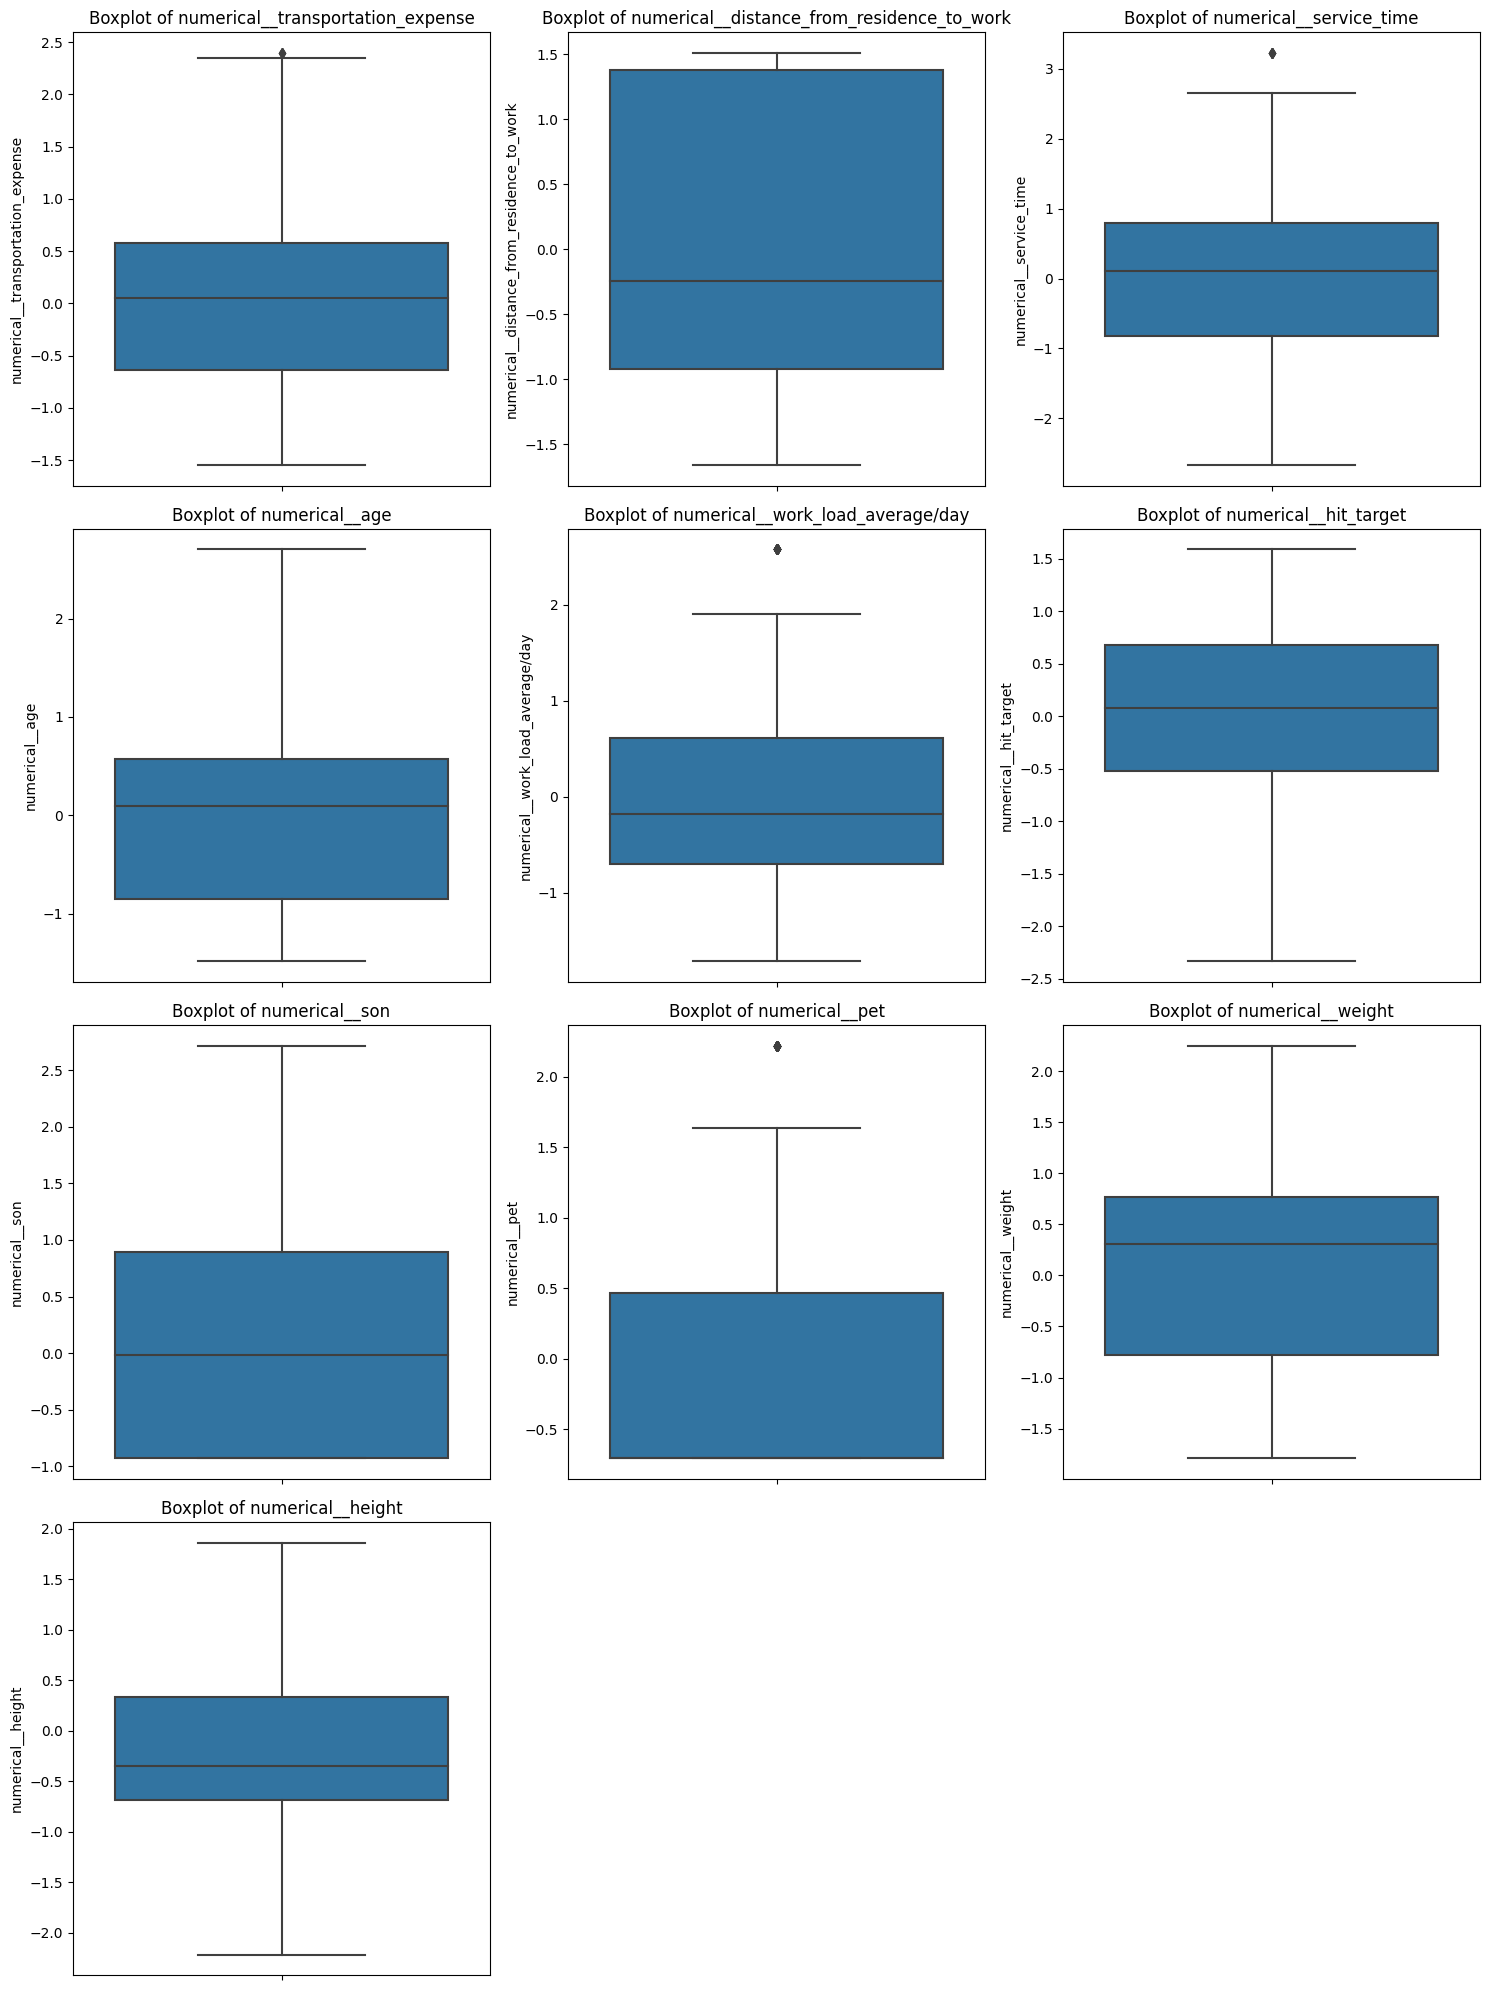

In [ ]:
columns = pipeline.named_steps['preprocess'].get_feature_names_out()
transformed_df = pd.DataFrame(transformed_data, columns=columns)
plot_numerical_boxplots(transformed_df, columns)

We can also add a column transformer for categorical columns

In [ ]:
class ToStringTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col in X.columns:
            X[col] = X[col].astype(str)
        return X

    def get_feature_names_out(self, input_features=None):
        return input_features if input_features is not None else []


In [ ]:
pipeline = Pipeline([
    ('drop_columns', DropColumnsTransformer(columns_to_drop)),
    ('preprocess', ColumnTransformer(
        transformers=[
            ('numerical', Pipeline([
                ('iqr_clipping', IQRClippingTransformer()),
                ('scaling', StandardScaler())
            ]), numerical_columns),
            ('categorical', Pipeline([
                ('to_string', ToStringTransformer()),
                ('one_hot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
            ]), categorical_columns)
        ],
        remainder='passthrough'
    ))
])


In [ ]:
transformed_data = pipeline.fit_transform(df)

In [ ]:
columns = pipeline.named_steps['preprocess'].get_feature_names_out()
transformed_df = pd.DataFrame(transformed_data, columns=columns)

In [ ]:
transformed_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
numerical__transportation_expense,1.012777,-1.545473,-0.632881,0.863172,1.012777,-0.632881,2.089935,0.578922,-0.991933,0.204909
numerical__distance_from_residence_to_work,0.429556,-1.121694,1.441240,-1.661258,0.429556,1.441240,1.508686,1.373794,-1.189139,-1.256585
numerical__service_time,0.107066,1.263697,1.263697,0.338393,0.107066,1.263697,-2.206195,-0.355586,0.338393,0.338393
numerical__age,-0.537549,2.149126,0.252650,0.410690,-0.537549,0.252650,-1.327747,-0.063429,-0.379509,0.094610
numerical__work_load_average/day,-0.830594,-0.830594,-0.830594,-0.830594,-0.830594,-0.830594,-0.830594,-0.830594,-0.830594,-0.830594
...,...,...,...,...,...,...,...,...,...,...
categorical__social_drinker_0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
categorical__social_drinker_1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
categorical__social_smoker_0,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
categorical__social_smoker_1,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
